In [4]:
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import jax.scipy.stats as stats
from jax import jacfwd, jacrev
from jax import vmap, grad, jit, random
from jax.tree_util import tree_map, tree_flatten, tree_unflatten, tree_leaves

from flax import nnx
import optax
import pcax

from tqdm.notebook import tqdm
from tqdm.notebook import trange

import torch
from torch.utils.data import DataLoader, TensorDataset

In [5]:
import os
os.chdir('../methods')
import lsci, supr, conf, uqno
os.chdir('../energy')

In [6]:
def clocktime():
    hours = []
    for i in range(24):
        j = i
        if i % 12 == 0: j = 12

        if i < 12:
            hours.append(f'{j} ' + 'AM') 
        elif i == 12:
            hours.append(f'{j} ' + 'PM') 
        else:
            hours.append(f'{j-12} ' + 'PM')
    return hours

In [7]:
def risk(lower, upper, residual):
    return jnp.mean((residual > lower)*(residual < upper))

In [8]:
def split_data(data, lag, horizon):
    horizon = horizon-1
    y_t = data[(lag + horizon):][:,None]
    x_t = np.stack([data[(lag-i-1):(-(i+1+horizon))] for i in range(lag)], axis = 1)
    return x_t.copy(), y_t.copy()

def torch2jax(x):
    return jnp.array(x.numpy())

In [9]:
class ANO_layer(nnx.Module):
    def __init__(self, width, rngs: nnx.Rngs):
        self.conv = nnx.Conv(width, width, (1, 1), rngs=rngs)
        self.conv_out = nnx.Conv(width, width, (1, 1), rngs=rngs)
        
    def __call__(self, x):
        # channel mix
        h = self.conv(x)

        # spatial mix
        g = jnp.mean(x, axis = (1, 2))[:,None,None,:]

        # sum
        x = h + g
        x = nnx.relu(x)

        return self.conv_out(x)

class encode_layer(nnx.Module):
    def __init__(self, in_dim, out_dim, rngs):
        self.conv = nnx.Conv(in_dim, out_dim, (1, 1), rngs=rngs)

    def __call__(self, x):
        return self.conv(x)

class DeepANO(nnx.Module):
    def __init__(self, in_dim, width, out_dim, rngs):
        self.encode_layer = encode_layer(in_dim, width, rngs)
        self.ano1 = ANO_layer(width, rngs)
        self.ano2 = ANO_layer(width, rngs)
        self.ano3 = ANO_layer(width, rngs)
        self.decode_layer = encode_layer(width, out_dim, rngs)

#     def __call__(self, x):
#         x = self.encode_layer(x)
#         x = self.ano1(x)
#         x = self.ano2(x)
#         x = self.ano3(x)
#         x = self.decode_layer(x)
#         return x
    
    def __call__(self, x):
        f = self.encode_layer(x)
        f = self.ano1(f)
        f = self.ano2(f)
        f = self.ano3(f)
        f = self.decode_layer(f)
        return f + jnp.mean(x, axis = -1)[:,:,:,None]

In [10]:
def train_step(model, optimizer, x, y):
    def loss_fn(model):
        y_pred = model(x)
        return jnp.mean((y_pred - y) ** 2)

    loss, grads = nnx.value_and_grad(loss_fn)(model)
    optimizer.update(grads)  # In place updates.

    return loss

def quant_step(model, optimizer, x, y):
    def loss_fn(model):
        quant = 1 - 0.1
        y_pred = model(x)
        y_abs = jnp.abs(y)
        resid = y_abs - y_pred
        loss = jnp.max(jnp.concat([quant * resid, -(1-quant) * resid], axis = 3), axis = 3)
        return jnp.mean(loss)
    
    loss, grads = nnx.value_and_grad(loss_fn)(model)
    optimizer.update(grads)  # in-place updates

    return loss

train_step = nnx.jit(train_step)
quant_step = nnx.jit(quant_step)

In [11]:
# https://www.eia.gov/electricity/gridmonitor/dashboard/electric_overview/US48/US48
import pandas as pd
energy = pd.read_excel('../data/tx_energy.xlsx')

In [13]:
energy.head()

,Region,UTC time,Local date,Hour,Local time,Time zone,Demand forecast,Demand,Net generation,Total interchange,...,CO2 Emissions: OIL,CO2 Emissions: Other,CO2 Emissions Generated,CO2 Emissions Imported,CO2 Emissions Exported,CO2 Emissions Consumed,Positive Generation,Consumed Electricity,CO2 Emissions Intensity for Generated Electricity,CO2 Emissions Intensity for Consumed Electricity
0,TEX,2015-07-01 06:00:00,2015-07-01,1,2015-07-01 01:00:00,Central,39708.0,37456.0,37462.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TEX,2015-07-01 07:00:00,2015-07-01,2,2015-07-01 02:00:00,Central,37338.0,35119.0,35124.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TEX,2015-07-01 08:00:00,2015-07-01,3,2015-07-01 03:00:00,Central,35697.0,33638.0,33642.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TEX,2015-07-01 09:00:00,2015-07-01,4,2015-07-01 04:00:00,Central,34772.0,32798.0,32805.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TEX,2015-07-01 10:00:00,2015-07-01,5,2015-07-01 05:00:00,Central,34773.0,32805.0,32812.0,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
energy.tail()

,Region,UTC time,Local date,Hour,Local time,Time zone,Demand forecast,Demand,Net generation,Total interchange,...,CO2 Emissions: OIL,CO2 Emissions: Other,CO2 Emissions Generated,CO2 Emissions Imported,CO2 Emissions Exported,CO2 Emissions Consumed,Positive Generation,Consumed Electricity,CO2 Emissions Intensity for Generated Electricity,CO2 Emissions Intensity for Consumed Electricity
84524,TEX,2025-02-20 02:00:00,2025-02-19,20,2025-02-19 20:00:00,Central,70119.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
84525,TEX,2025-02-20 03:00:00,2025-02-19,21,2025-02-19 21:00:00,Central,71294.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
84526,TEX,2025-02-20 04:00:00,2025-02-19,22,2025-02-19 22:00:00,Central,70807.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
84527,TEX,2025-02-20 05:00:00,2025-02-19,23,2025-02-19 23:00:00,Central,68141.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
84528,TEX,2025-02-20 06:00:00,2025-02-19,24,2025-02-20 00:00:00,Central,66969.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
energy_curves =  energy.groupby('Local date')['Demand'].apply(list).reset_index()
energy_curves = np.array(energy_curves)
dts = energy_curves[:,0]
fns = energy_curves[:,1]

In [10]:
# transform
fns = [np.array(f) for f in fns]
fns = [jax.image.resize(f, 24, 'bicubic') for f in fns]
fns = np.array(fns)

# backfill missing
missing = jnp.sum(jnp.isnan(fns), axis = 1) > 0
for i in range(fns.shape[0]):
    if missing[i]:
        fns[i] = fns[i-1]

# rescale
# fns = (fns - jnp.mean(fns, axis = 0)[None,:]) / jnp.std(fns, axis = 0)[None,:]
energy_mean, energy_std =  jnp.mean(fns, axis = 1)[:,None], jnp.std(fns, axis = 1)[:,None]
fns0 = fns.copy()
fns = (fns - energy_mean) / energy_std
fns = jnp.array(fns)

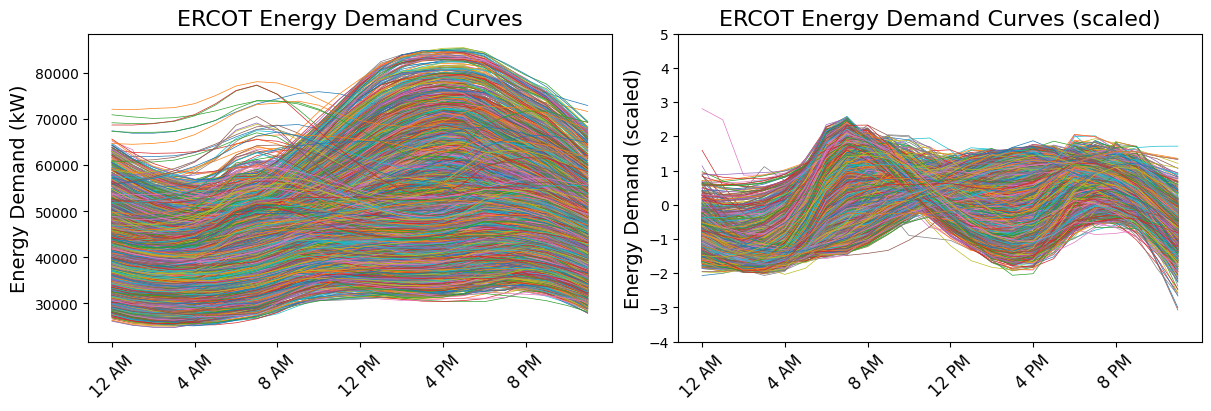

In [11]:
### examples
fig, ax = plt.subplots(1, 2, constrained_layout = True, figsize = (12, 4))

hours = clocktime()
s = np.arange(24)

# ax[0].set_ylim(-4, 5)
ax[0].plot(fns0.T, lw = 0.5)
ax[0].set_xticks(s[::4], hours[::4], rotation=45, fontsize = 12)
ax[0].set_ylabel('Energy Demand (kW)', fontsize = 14)
ax[0].set_title(f'ERCOT Energy Demand Curves', fontsize = 16)

ax[1].set_ylim(-4, 5)
ax[1].plot(fns.T, lw = 0.5)
ax[1].set_xticks(s[::4], hours[::4], rotation=45, fontsize = 12)
ax[1].set_ylabel('Energy Demand (scaled)', fontsize = 14)
ax[1].set_title(f'ERCOT Energy Demand Curves (scaled)', fontsize = 16)
plt.show()

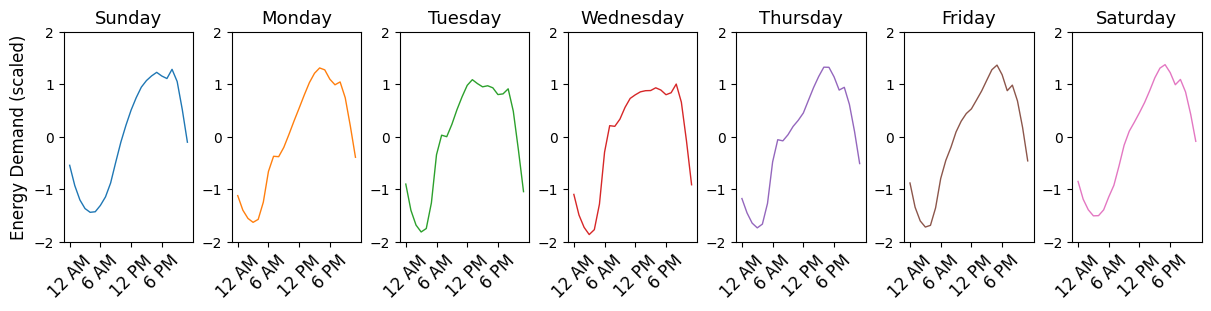

In [12]:
### examples
fig, ax = plt.subplots(1, 7, constrained_layout = True, figsize = (12, 3))

days = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
hours = clocktime()
s = np.arange(24)

for i in range(7):
    ax[i].set_ylim(-2, 2)
    if i == 0: ax[i].set_ylabel('Energy Demand (scaled)', fontsize = 12)
    ax[i].plot(fns[998+i], c=f'C{i}', lw = 1.0)
    ax[i].set_xticks(s[::6], hours[::6], rotation=45, fontsize = 12)
    ax[i].set_title(f'{days[i]}', fontsize = 13)
plt.show()

In [20]:
# ### examples
# fig, ax = plt.subplots(1, 4, constrained_layout = True, figsize = (12, 3))

# days = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
# hours = clocktime()
# s = np.arange(24)

# for i in range(4):
#     ax[i].set_ylim(-2, 2)
#     if i == 0: ax[i].set_ylabel('Energy Demand (scaled)', fontsize = 12)
#     ax[i].plot(fns[998+i], c=f'C{i}', lw = 1.0)
#     ax[i].set_xticks(s[::6], hours[::6], rotation=45, fontsize = 12)
#     ax[i].set_title(f'{days[i]}', fontsize = 13)

# plt.show()

In [14]:
lag = 1
lead = 1
x, y = split_data(fns, lag, 1)
ntrain, nval = 1500, 2500

xtrain = x[:ntrain].reshape(-1, 1, 24, lag)
ytrain = y[:ntrain].reshape(-1, 1, 24, lead)

xval = x[ntrain:nval].reshape(-1, 1, 24, lag)
yval = y[ntrain:nval].reshape(-1, 1, 24, lead)

xtest = x[nval:].reshape(-1, 1, 24, lag)
ytest = y[nval:].reshape(-1, 1, 24, lead)

train_data = TensorDataset(torch.Tensor(xtrain), torch.Tensor(ytrain))
train_loader = DataLoader(train_data, batch_size = 30, shuffle = True)

In [15]:
epochs = 50
trace = []

model = DeepANO(lag, 32, lead, rngs=nnx.Rngs(0))
optim = nnx.Optimizer(model, optax.adam(1e-3))
rng = random.PRNGKey(0)

for _ in trange(epochs):
    for xt, yt in train_loader:
        xt = torch2jax(xt)
        yt = torch2jax(yt)
        
        loss = train_step(model, optim, xt, yt)
        trace.append(loss)

  0%|          | 0/50 [00:00<?, ?it/s]

In [16]:
quant = DeepANO(lag, 32, lead, rngs=nnx.Rngs(0))
optim = nnx.Optimizer(quant, optax.adam(1e-3))
rng = random.PRNGKey(0)

for _ in trange(epochs):
    for xt, yt in train_loader:
        xt = torch2jax(xt)
        yt = torch2jax(yt)
        
        loss = quant_step(quant, optim, xt, yt)
        trace.append(loss)

  0%|          | 0/50 [00:00<?, ?it/s]

In [17]:
yval_hat = model(xval)
ytest_hat = model(xtest)
yval_quant = quant(xval)
ytest_quant = quant(xtest)

In [18]:
jnp.mean((yval_hat - yval)**2), jnp.mean((ytest_hat - ytest)**2)

(Array(0.2167076, dtype=float32), Array(0.18084799, dtype=float32))

In [21]:
# plt.plot(yval_hat.squeeze()[800])
# plt.plot(yval.squeeze()[800])

In [22]:
# UQNO lambda estimate
yval_quant = yval.reshape(yval_quant.shape[0], -1)
ytest_quant = ytest_quant.reshape(ytest_quant.shape[0], -1)

alpha = 0.1
delta = 0.1
# m = 32*64
m = 24
tau = 20 * jnp.sqrt(-jnp.log(delta)/(2*m))
sg = jnp.abs(yval.squeeze() - yval_hat.squeeze()) / yval_quant
sg = jnp.quantile(sg, 1-alpha+tau, axis = (1))
nval = sg.shape[0]

adj_alpha = 1 - jnp.ceil((nval + 1) * (delta - jnp.exp(-2*m*tau**2)))/nval
lam_uqno = jnp.quantile(sg, adj_alpha) * 1/10
lam_uqno

Array(1.8322151, dtype=float32)

In [23]:
nproj = 24
gamma1 = 0.1
gamma2 = 0.05
alpha = 0.1
nval = xval.shape[0]
alpha1 = 1 - jnp.ceil((1-alpha) * (gamma1*nval + 1))/(gamma1*nval)

lsc1_rc = []
lsc2_rc = []
conf_rc = []
supr_rc = []
uqn1_rc = []

lsc1_width = []
lsc2_width = []
conf_width = []
supr_width = []
uqn1_width = []

yval = yval.reshape(yval.shape[0], -1)
yval_hat = yval_hat.reshape(yval_hat.shape[0], -1)
pca_state = lsci.phi_state(yval, yval_hat, nproj)

rval = (yval - yval_hat).squeeze()
rtest = (ytest - ytest_hat).squeeze()

conf_lower, conf_upper = conf.conf_band(rval, pca_state, alpha)
supr_lower, supr_upper = supr.supr_band(rval, alpha)
uqn1_lower, uqn1_upper = uqno.uqno_band(ytest_quant, lam_uqno)

for i in trange(0, ytest.shape[0]):
# for i in trange(0, 100):
    
    # LSCI
    lsc1_lower, lsc1_upper = lsci.lsci(rval, xval, xtest[i], pca_state, alpha1, gamma1, 2000)
    lsc1_rc.append(risk(lsc1_lower, lsc1_upper, rtest[i]))
    lsc1_width.append(jnp.median(lsc1_upper - lsc1_lower))
    
    # LSCI
    lsc2_lower, lsc2_upper = lsci.lsci(rval, xval, xtest[i], pca_state, alpha1, gamma2, 2000)
    lsc2_rc.append(risk(lsc2_lower, lsc2_upper, rtest[i]))
    lsc2_width.append(jnp.median(lsc2_upper - lsc2_lower))
    
    # CONF 
    conf_rc.append(risk(conf_lower, conf_upper, rtest[i]))
    conf_width.append(jnp.mean(conf_upper - conf_lower))
    
    # SUPR
    supr_rc.append(risk(supr_lower, supr_upper, rtest[i]))
    supr_width.append(jnp.mean(supr_upper - supr_lower))
    
    # UQNO
    uqn1_rc.append(risk(uqn1_lower[i], uqn1_upper[i], rtest[i]))
    uqn1_width.append(jnp.mean(uqn1_upper[i] - uqn1_lower[i]))

    
conf_rc = np.array(conf_rc)
supr_rc = np.array(supr_rc)
uqn1_rc = np.array(uqn1_rc)
lsc1_rc = np.array(lsc1_rc)
lsc2_rc = np.array(lsc2_rc)

conf_width = np.array(conf_width)
supr_width = np.array(supr_width)
uqn1_width = np.array(uqn1_width)
lsc1_width = np.array(lsc1_width)
lsc2_width = np.array(lsc2_width)

  0%|          | 0/1021 [00:00<?, ?it/s]

In [24]:
noise_sd = np.std(rtest, axis = 1)[:conf_rc.shape[0]]

risk_control = np.mean(conf_rc >= 0.99), \
               np.mean(supr_rc >= 0.99), \
               np.mean(uqn1_rc >= 0.99), \
               np.mean(lsc1_rc >= 0.99), \
               np.mean(lsc2_rc >= 0.99)

width = np.mean(conf_width), \
        np.mean(supr_width), \
        np.mean(uqn1_width), \
        np.mean(lsc1_width), \
        np.mean(lsc2_width)

risk_cor = np.corrcoef([noise_sd, conf_rc])[0,1], \
           np.corrcoef([noise_sd, supr_rc])[0,1], \
           np.corrcoef([noise_sd, uqn1_rc])[0,1], \
           np.corrcoef([noise_sd, lsc1_rc])[0,1], \
           np.corrcoef([noise_sd, lsc2_rc])[0,1]

width_cor = 0, \
            0, \
            np.corrcoef([noise_sd, uqn1_width])[0,1], \
            np.corrcoef([noise_sd, lsc1_width])[0,1], \
            np.corrcoef([noise_sd, lsc2_width])[0,1]

metrics = np.array([risk_control, risk_cor, width, width_cor]).T

In [25]:
np.set_printoptions(suppress=True)
print(np.round(metrics, 3))

[[ 0.96  -0.552  3.813  0.   ]
 [ 0.919 -0.704  3.102  0.   ]
 [ 0.93  -0.532  4.308  0.587]
 [ 0.938 -0.263  1.878  0.716]
 [ 0.925 -0.273  1.711  0.728]]


In [26]:
for i in range(metrics.shape[0]):
    for j in range(metrics.shape[1]):
        val = f'{np.round(metrics[i,j], 3):.3f}'
        if j < 3:
            val += ' & '
            print(val, end = '')
        else:
            val += ' \\\\'
            print(val)

0.960 & -0.552 & 3.813 & 0.000 \\
0.919 & -0.704 & 3.102 & 0.000 \\
0.930 & -0.532 & 4.308 & 0.587 \\
0.938 & -0.263 & 1.878 & 0.716 \\
0.925 & -0.273 & 1.711 & 0.728 \\


In [28]:
oracle_rc = []
oracle_width = []
for i in trange(0, ytest.shape[0]):
    
    # Oracle    
    oracle_lower = jnp.min(rtest[i]) * jnp.ones((24,)) - 1e-7
    oracle_upper = jnp.max(rtest[i]) * jnp.ones((24,)) + 1e-7
    oracle_rc.append(risk(oracle_lower, oracle_upper, rtest[i]))
    oracle_width.append(jnp.mean(oracle_upper - oracle_lower))

oracle_rc = np.array(oracle_rc)
oracle_width = np.array(oracle_width)

  0%|          | 0/1021 [00:00<?, ?it/s]

In [29]:
noise_sd = np.std(rtest, axis = 1)

risk_control = np.mean(oracle_rc >= 0.99), \
               np.mean(conf_rc >= 0.99), \
               np.mean(supr_rc >= 0.99), \
               np.mean(uqn1_rc >= 0.99), \
               np.mean(lsc1_rc >= 0.99), \
               np.mean(lsc2_rc >= 0.99)

width = np.mean(oracle_width), \
        np.mean(conf_width), \
        np.mean(supr_width), \
        np.mean(uqn1_width), \
        np.mean(lsc1_width), \
        np.mean(lsc2_width)

risk_cor = 0, \
           np.corrcoef([noise_sd, conf_rc])[0,1], \
           np.corrcoef([noise_sd, supr_rc])[0,1], \
           np.corrcoef([noise_sd, uqn1_rc])[0,1], \
           np.corrcoef([noise_sd, lsc1_rc])[0,1], \
           np.corrcoef([noise_sd, lsc2_rc])[0,1]

width_cor = np.corrcoef([noise_sd, oracle_width])[0,1], \
            0, \
            0, \
            np.corrcoef([noise_sd, uqn1_width])[0,1], \
            np.corrcoef([noise_sd, lsc1_width])[0,1], \
            np.corrcoef([noise_sd, lsc2_width])[0,1]

metrics = np.array([risk_control, risk_cor, width, width_cor]).T

In [30]:
for i in range(metrics.shape[0]):
    for j in range(metrics.shape[1]):
        val = f'{np.round(metrics[i,j], 3):.3f}'
        if j < 3:
            val += ' & '
            print(val, end = '')
        else:
            val += ' \\\\'
            print(val)

0.974 & 0.000 & 1.085 & 0.979 \\
0.960 & -0.552 & 3.813 & 0.000 \\
0.919 & -0.704 & 3.102 & 0.000 \\
0.930 & -0.532 & 4.308 & 0.587 \\
0.938 & -0.263 & 1.878 & 0.716 \\
0.925 & -0.273 & 1.711 & 0.728 \\


In [561]:
arclen = jnp.sum(jnp.diff(rtest, axis = 1)**2, axis = 1)

In [143]:
# plt.plot(2 * noise_sd)
# plt.plot(lsc1_width)
# plt.plot(uqn1_width)
# plt.plot(conf_width)
# plt.plot(supr_width)
# jnp.argmin(arclen), jnp.argmax(arclen)

In [105]:
hours = []
for i in range(24):
    j = i
    if i % 12 == 0: j = 12
        
    if i < 12:
        hours.append(f'{j} ' + 'AM') 
    elif i == 12:
        hours.append(f'{j} ' + 'PM') 
    else:
        hours.append(f'{j-12} ' + 'PM')

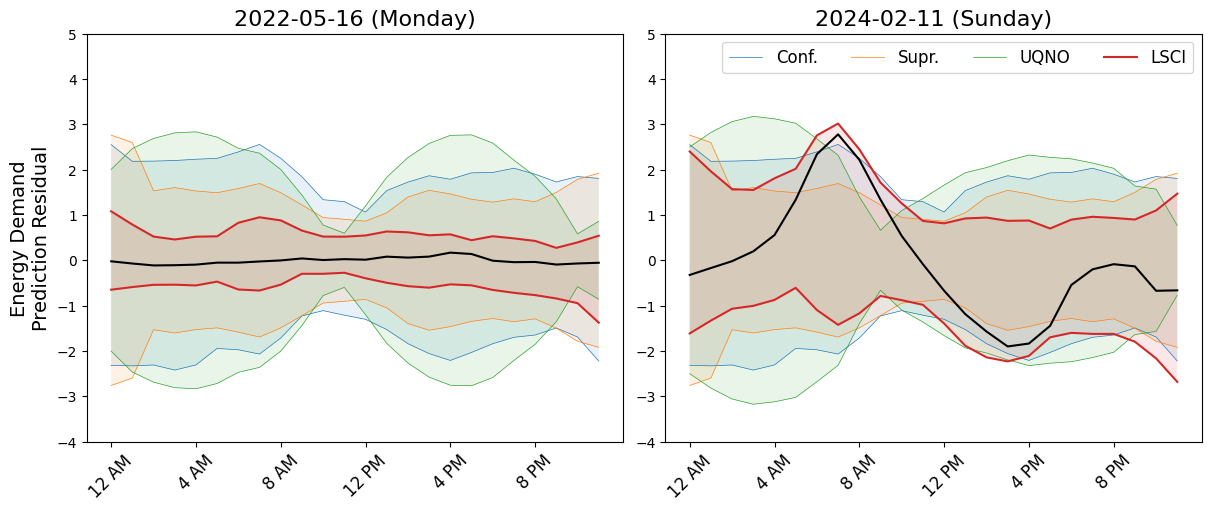

In [142]:
### examples
fig, ax = plt.subplots(1, 2, constrained_layout = True, figsize = (12, 5))

n1 = 11
lsc1_lower, lsc1_upper = lsci.lsci(rval, xval, xtest[n1], pca_state, alpha1, gamma1, 2000)
uqno_lower, uqno_upper = uqn1_lower[n1], uqn1_upper[n1]

ax[0].set_ylim(-4, 5)
ax[0].plot(conf_upper.squeeze(), c = 'C0', lw = 0.5)
ax[0].plot(conf_lower.squeeze(), c = 'C0', lw = 0.5)
ax[0].plot(supr_upper.squeeze(), c = 'C1', lw = 0.5)
ax[0].plot(supr_lower.squeeze(), c = 'C1', lw = 0.5)
ax[0].plot(uqno_upper, c = 'C2', lw = 0.5)
ax[0].plot(uqno_lower, c = 'C2', lw = 0.5)
ax[0].plot(lsc1_upper, c = 'C3', lw = 1.5)
ax[0].plot(lsc1_lower, c = 'C3', lw = 1.5)
ax[0].plot(rtest[n1], c = 'black')

s = np.arange(24)
ax[0].fill_between(s, conf_lower.squeeze(), conf_upper.squeeze(), alpha = 0.1)
ax[0].fill_between(s, supr_lower.squeeze(), supr_upper.squeeze(), alpha = 0.1)
ax[0].fill_between(s, uqno_lower.squeeze(), uqno_upper.squeeze(), alpha = 0.1)
ax[0].fill_between(s, lsc1_lower.squeeze(), lsc1_upper.squeeze(), alpha = 0.1)

n2 = 647
lsc1_lower, lsc1_upper = lsci.lsci(rval, xval, xtest[n2], pca_state, alpha1, gamma1, 2000)
uqno_lower, uqno_upper = uqn1_lower[n2], uqn1_upper[n2]

ax[1].set_ylim(-4, 5)
ax[1].plot(conf_upper.squeeze(), c = 'C0', lw = 0.5, label = 'Conf.')
ax[1].plot(conf_lower.squeeze(), c = 'C0', lw = 0.5)
ax[1].plot(supr_upper.squeeze(), c = 'C1', lw = 0.5, label = 'Supr.')
ax[1].plot(supr_lower.squeeze(), c = 'C1', lw = 0.5)
ax[1].plot(uqno_upper, c = 'C2', lw = 0.5, label = 'UQNO')
ax[1].plot(uqno_lower, c = 'C2', lw = 0.5)
ax[1].plot(lsc1_upper, c = 'C3', lw = 1.5, label = 'LSCI')
ax[1].plot(lsc1_lower, c = 'C3', lw = 1.5)
ax[1].plot(rtest[n2], c = 'black')

s = np.arange(24)
ax[1].fill_between(s, conf_lower.squeeze(), conf_upper.squeeze(), alpha = 0.1)
ax[1].fill_between(s, supr_lower.squeeze(), supr_upper.squeeze(), alpha = 0.1)
ax[1].fill_between(s, uqno_lower.squeeze(), uqno_upper.squeeze(), alpha = 0.1)
ax[1].fill_between(s, lsc1_lower.squeeze(), lsc1_upper.squeeze(), alpha = 0.1)
 
ax[0].set_xticks(s[::4], hours[::4], rotation=45, fontsize = 12)
ax[1].set_xticks(s[::4], hours[::4], rotation=45, fontsize = 12)

ax[0].set_ylabel('Energy Demand\nPrediction Residual', fontsize = 14)

ax[0].set_title(f'{np.datetime64(dts[ntrain + nval + n1], "D")} (Monday)', fontsize = 16)
ax[1].set_title(f'{np.datetime64(dts[ntrain + nval + n2], "D")} (Sunday)', fontsize = 16)

ax[1].legend(ncol = 4, fontsize = 12)
plt.show()